In [331]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom


#MNIST dataset
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.models import DnCNN, DRUNet

#local imports (Radon transform, Gaussian noise, FBP, PSNR and PnP-PGD, PnP-FISTA, PnP-ADMM algorithms and all the plotting functions)
from radon import forward_operator_radon, add_noise, fbp
from algorithms import *
from plotting import *

#Reproducible results
torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])

In [40]:
#For plots
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          "font.size": 20,
          "text.usetex": True,
          "font.family": "Computer Modern Roman",
          #"label.fontsize": 18
          }
plot.rcParams.update(params)

In [3]:
#Radon transform
n = 84
n_angles = 60
phantom = resize(shepp_logan_phantom(), (n,n))
A = forward_operator_radon(n, n_angles)


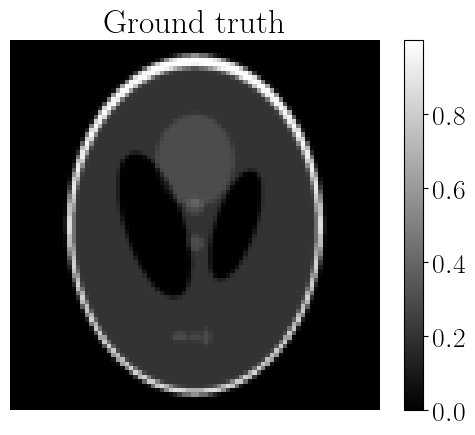

In [329]:
plt.imshow(phantom, cmap = 'gray')
plt.title('Ground truth')
plt.axis('off')
plt.colorbar()

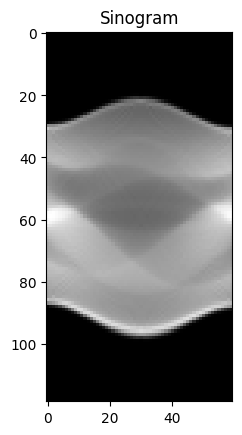

In [5]:
imsize = (n, n)
phantom = resize(shepp_logan_phantom(), (n,n))
y = np.reshape(A@phantom.flatten(), (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')
#ground truth
x = torch.from_numpy(phantom).flatten().float()


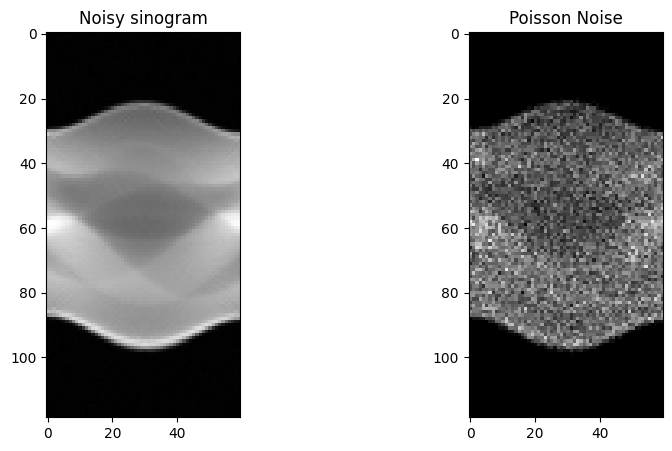

In [6]:
# Add Gaussian and Poisson noise to the sinogram
sigma = 0.05
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma).float()
poisson_y = add_noise(y, noise_type='poisson').float()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy sinogram")
plt.imshow(gauss_y.numpy(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Poisson Noise")
plt.imshow(poisson_y.numpy(), cmap='gray')

Text(0.5, 1.0, 'Noise-free FBP reconstruction')

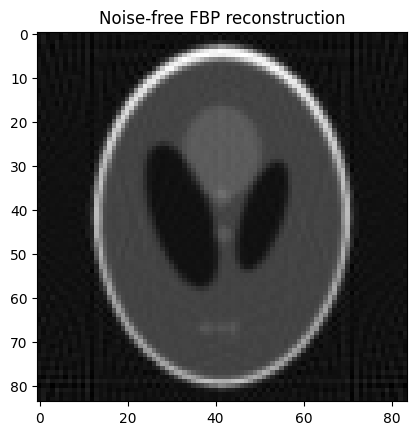

In [7]:
#Noise free FBP

reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


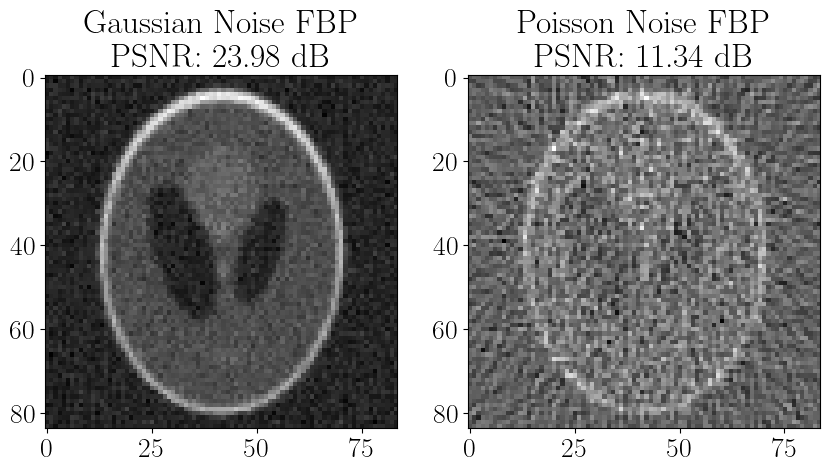

In [186]:
#Noisy reconstruction
s = 0.05
gfbp = fbp(gauss_y, n_angles)
pfbp = fbp(poisson_y, n_angles)
gfbp =  gfbp.reshape(n, n) + torch.randn(n,n)*s
g_psnr = PSNR(x, gfbp)
p_psnr = PSNR(x, pfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Poisson Noise FBP \n PSNR: {p_psnr:.2f} dB")
plt.imshow(pfbp, cmap='gray')

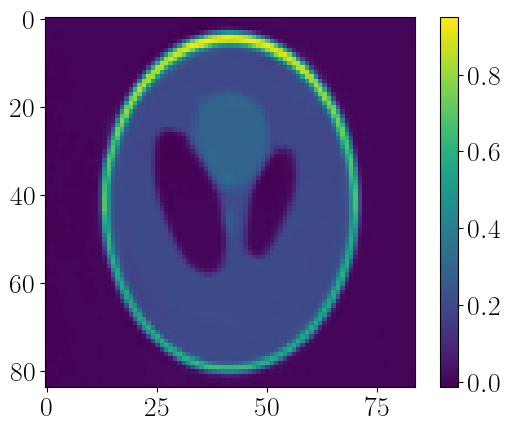

In [136]:
w = gfbp.reshape(imsize)
#print("x shape before:", x.shape)
w = w.unsqueeze(0).unsqueeze(0)
#print("x shape after:", x.shape)

#w = dncnn(w, sigma = 1e-1)
w = gsdrunet(w, sigma = 0.05)
#w = gsdrunet(w, sigma = s)
w =  w.squeeze(0).squeeze(0).detach()

plt.imshow(w.reshape(imsize).numpy())
plt.colorbar()

In [15]:
# plotting functions
def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        psnr = PSNR(ground_truth, img)
        titles.append(title + f' PSNR: {psnr:.2f} dB \n')
        

        #nrmse = pnpm.nrmse(img, ground_truth)
        #titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img, cmap='gray')
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()

# Optimisation algorithms (PGD and ADMM) for reconstruction (priors)

In [11]:
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

In [12]:
#GS-DRUNet class with GSPnP and the GS-DRUNet function
import torch
import torch.nn as nn
from deepinv.models.utils import get_weights_url



class StudentGrad(nn.Module):
    def __init__(self, denoiser):
        super().__init__()
        self.model = denoiser

    def forward(self, x, sigma):
        return self.model(x, sigma)


class GSPnP(nn.Module):
    r"""
    Gradient Step module to use a denoiser architecture as a Gradient Step Denoiser.
    See https://arxiv.org/pdf/2110.03220.pdf.
    Code from https://github.com/samuro95/GSPnP.

    :param nn.Module denoiser: Denoiser model.
    :param float alpha: Relaxation parameter
    """

    def __init__(self, denoiser, alpha=1.0, train=False):
        super().__init__()
        self.student_grad = StudentGrad(denoiser)
        self.alpha = alpha
        self.train = train

    def potential(self, x, sigma, *args, **kwargs):
        N = self.student_grad(x, sigma)
        return (
            0.5
            * self.alpha
            * torch.norm((x - N).view(x.shape[0], -1), p=2, dim=-1) ** 2
        )

    def potential_grad(self, x, sigma, *args, **kwargs):
        r"""
        Calculate :math:`\nabla g` the gradient of the regularizer :math:`g` at input :math:`x`.

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level :math:`\sigma` (std)
        """
        with torch.enable_grad():
            x = x.float()
            x = x.requires_grad_()
            N = self.student_grad(x, sigma)
            JN = torch.autograd.grad(
                N, x, grad_outputs=x - N, create_graph=True, only_inputs=True
            )[0]
        Dg = x - N - JN
        return self.alpha * Dg

    def forward(self, x, sigma):
        r"""
        Denoising with Gradient Step Denoiser

        :param torch.Tensor x: Input image
        :param float sigma: Denoiser level (std)
        """
        Dg = self.potential_grad(x, sigma)
        x_hat = x - Dg
        return x_hat


def GSDRUNet(
    alpha=1.0,
    in_channels=3,
    out_channels=3,
    nb=2,
    nc=[64, 128, 256, 512],
    act_mode="E",
    pretrained=None,
    train=False,
    device=torch.device("cpu"),
):
    """
    Gradient Step Denoiser with DRUNet architecture

    :param float alpha: Relaxation parameter
    :param int in_channels: Number of input channels
    :param int out_channels: Number of output channels
    :param int nb: Number of blocks in the DRUNet
    :param list nc: Number of channels in the DRUNet
    :param str act_mode: activation mode, "R" for ReLU, "L" for LeakyReLU "E" for ELU and "S" for Softplus.
    :param str downsample_mode: Downsampling mode, "avgpool" for average pooling, "maxpool" for max pooling, and
        "strideconv" for convolution with stride 2.
    :param str upsample_mode: Upsampling mode, "convtranspose" for convolution transpose, "pixelsuffle" for pixel
        shuffling, and "upconv" for nearest neighbour upsampling with additional convolution.
    :param bool download: use a pretrained network. If ``pretrained=None``, the weights will be initialized at random
        using Pytorch's default initialization. If ``pretrained='download'``, the weights will be downloaded from an
        online repository (only available for the default architecture).
        Finally, ``pretrained`` can also be set as a path to the user's own pretrained weights.
        See :ref:`pretrained-weights <pretrained-weights>` for more details.
    :param bool train: training or testing mode.
    :param str device: gpu or cpu.

    """
    from deepinv.models.drunet import DRUNet

    denoiser = DRUNet(
        in_channels=in_channels,
        out_channels=out_channels,
        nb=nb,
        nc=nc,
        act_mode=act_mode,
        pretrained=None,
        train=train,
        device=device,
    )
    GSmodel = GSPnP(denoiser, alpha=alpha, train=train)
    if pretrained:
        if pretrained == "download":
            if in_channels == 3 and out_channels == 3:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_torch.ckpt",
                )
            elif in_channels == 1 and out_channels == 1:
                url = get_weights_url(
                    model_name="gradientstep", file_name="GSDRUNet_grayscale_torch.ckpt"
                )
                ckpt = torch.hub.load_state_dict_from_url(
                    url,
                    map_location=lambda storage, loc: storage,
                    file_name="GSDRUNet_grayscale_torch.ckpt",
                )
        else:
            ckpt = torch.load(pretrained, map_location=lambda storage, loc: storage)

        if "state_dict" in ckpt:
            ckpt = ckpt["state_dict"]

        GSmodel.load_state_dict(ckpt, strict=False)
    return GSmodel




In [13]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)



In [14]:
gsdrunet = GSDRUNet(
    in_channels= 1,
    out_channels= 1,
    pretrained="download",
    device="cpu",
)

#gsdrunet(x.reshape(imsize).unsqueeze(0).unsqueeze(0), sigma = sigma)

# Denoiser choice for the proximal operator

In [16]:
def soft_thresh(x, l):
    return torch.sign(x) * F.relu(torch.abs(x) - l)

def apply_denoiser(x, l, sigma = sigma,  method = 'tv'):
        """
        Denoiser options to replace the proximal step
        """
        if method == 'tv':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method == 'bm3d':
            #x = torch.to_numpy(x)
            #print(x.shape)
            x = bm3d(x.reshape(imsize), sigma_psd = sigma*5).flatten()
            return torch.from_numpy(x).float()
        elif method == 'proximal':
            return soft_thresh(x, l)
        elif method == 'DnCNN':
            #print('DnCNN')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x)
            return x.squeeze(0).squeeze(0)
        elif method == 'DRUNet':
            x = x.reshape(imsize)
            x = x.unsqueeze(0).unsqueeze(0)
            x = drunet(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten().detach()
        elif method == "GS-DRUNet":
            x = x.reshape(imsize)
            #print("x shape before:", x.shape)
            x = x.unsqueeze(0).unsqueeze(0)
            #print("x shape after:", x.shape)
            x = gsdrunet(x, sigma = sigma)
            x =  x.squeeze(0).squeeze(0)
            return x.flatten().detach()


# PnP-PGD and PnP-FISTA

In [17]:
#Upper bound for Lispchitz constant (L) and in turn the upper bound for the stepsize (1/L) - where the upper bound is the largest eigenvalue of the Hessian of f(x), i.e A^T A
H = A.T @ A
def power_method(A, num_iterations=1000, tol=1e-6):
    # Initialize a random vector b
    n = A.size(0)
    b = torch.randn(n, 1)

    # Perform the power method iterations
    for _ in range(num_iterations):
        # Multiply A with b
        Ab = torch.mm(A, b)

        # Estimate the eigenvalue
        eigenvalue_estimate = torch.dot(b.squeeze(), Ab.squeeze()) / torch.dot(b.squeeze(), b.squeeze())

        # Normalize b
        b = Ab / torch.norm(Ab)

        # Check for convergence
        if torch.norm(Ab - b * eigenvalue_estimate) < tol:
            break

    return eigenvalue_estimate.item()

# Example usage:
ev = power_method(H)
print(f"Largest eigenvalue estimate: {ev}")

Largest eigenvalue estimate: 4866.83056640625


In [315]:
gauss_y.shape

torch.Size([119, 60])

In [317]:
guess = A.T @ (gauss_y.flatten())

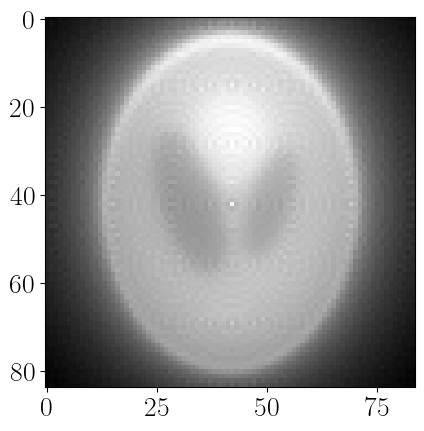

In [320]:
plt.imshow(guess.reshape(imsize), cmap= 'gray')

In [277]:
#PnP-PGD
#ISTA

def pnp_pgd(A, b, x_truth, method = None, reg_l = 1e-5, iters = 50, tol = 1e-3, sigma = sigma, L = ev):
    """
    PnP iterative shrinkage thrseholding algorithm (PnP-ISTA)
    """

    x = torch.zeros_like(x_truth, requires_grad=False)
    #x = fbp(b, n_angles).flatten()
    psnrs = []
    iterates_pairs = []
    differences = []
    increments =[]
    #L = torch.norm(A) ** 2  # Lipschitz constant
    t = 1 / L # Initial stepsize
    b = b.flatten()

    #f = lambda x: 0.5 * torch.norm(A @ x - b) ** 2
    #grad_f =lambda x: A.T @ (A @ x - b)
    #psnr.append(PSNR(x_truth, x))
    for i in tqdm(range(iters), desc = str(method) + '-PnP PGD iterations'):
        
        #gradient descent step
        current_grad = A.T @ (A @ x - b)
        #print("current gradient:", current_grad)
        x_new = x - (t * current_grad)
           
        """
        #backtracking line search (Armijo condition)
        while True:
            x_new = x - (t * current_grad)
            if (torch.norm(A @ (x_new - x)) ** 2) <=  t*(current_grad.T @ current_grad):
                break
            t *= 0.5
        """

        #denoising step (proximal step)
        denoised_x = apply_denoiser(x_new, reg_l, method = method, sigma = sigma)
        #x = soft_thresh(x_descent, l / L)

        #inverted and denoised iterates stored
        iterates_pairs.append((x_new, denoised_x))
        #difference between "noisy and denoised iterates"
        diff = x_new - denoised_x
        differences.append(diff)
        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)
        
        increments.append(torch.norm(x - denoised_x))
        #new estimate
        x = denoised_x
        psnr = PSNR(x_truth, x).detach()
        psnrs.append(psnr)
        if torch.norm(current_grad) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(current_grad), tol))
            break

    print(f"PnP-{method} Final PSNR: {psnr:.2f} dB")

    return x, psnrs, differences, iterates_pairs, increments



def pnp_fista(A, b, x_truth, method = None, reg_l = 1e-5, iters = 50, tol = 1e-3, sigma = sigma, L = ev):
    """
    PnP FISTA (accelerated PGD)
    """
    #ground = 0.5 * np.linalg.norm(A.dot(x_g) - b) ** 2 + l * np.linalg.norm(x_g, 1)
    x = torch.zeros_like(x_truth, requires_grad=False)
    #x = fbp(b, n_angles).flatten()
    psnrs = []
    iterates_pairs = []
    differences = []
    increments = []
    #L = torch.norm(A) ** 2  # Lipschitz constant
    #t = 1 / L # Initial stepsize
    b = b.flatten()
    

    #Initialisation of parameters (step size and initial guesses)
    t = 1
    z = x.clone()
    
    for i in tqdm(range(iters), desc = 'PnP FISTA iterations'):
        grad_g = A.T @ (A @ x - b)
        xold = x.clone()
        z = z + A.T @(b - A @ z) / L
        zold = z.clone()
        x = apply_denoiser(z, reg_l, method= method, sigma = sigma)
        t0 = t
        t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
        z = x + ((t0 - 1) / t) * (x - xold)
        
        incr = torch.norm(x - xold)
        increments.append(incr)

        #inverted and denoised iterates stored
        iterates_pairs.append((zold, x))
        #difference between "noisy and denoised iterates"
        diff = zold - x 
        differences.append(diff)

        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)

        psnr = PSNR(x_truth, x).detach()
        psnrs.append(psnr)
        if torch.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(grad_g), tol))
            break

    print(f"PnP-{method} Final PSNR: {psnr:.2f} dB")
    return x, psnrs, differences, iterates_pairs, increments



In [19]:
a, b, c, d, e = pnp_fista(A, gauss_y, x, method = 'DnCNN', iters = 50)

PnP FISTA iterations:   0%|          | 0/50 [00:00<?, ?it/s]

PnP FISTA iterations:   2%|▏         | 1/50 [00:00<00:05,  9.39it/s]C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\4046046829.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = (1 + torch.sqrt(torch.tensor(1 + 4 * t ** 2))) / 2.
PnP FISTA iterations: 100%|██████████| 50/50 [00:04<00:00, 11.67it/s]

PnP-DnCNN Final PSNR: 30.62 dB


In [ ]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
best = 0
b_lamb = 0
for lamb in lambdas:
    tv, tvp, tvd, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = lamb, iters = 200)
    if tvp[-1] > best:
        best = tvp[-1]
        b_lamb = lamb

print("Best PSNR:", best, "\n Best lambda:", b_lamb)

In [ ]:
sigmas = [1e-6, 1e-5, 1e-4]
best_s = 0
best_p = 0
for s in sigmas:
    x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', sigma = s)
    if drur[-1] >= best_p:
        best_s = s 
        best_p = drur[-1]
    #bm3, bm3r, bm3diff, bm3dpairs = pnp_pgd(A, gauss_y, x, method = 'bm3d', sigma = s)
    #plt.imshow(prox.reshape(imsize), cmap ='gray')

print("Best PSNR:", best_p, "\n Best sigma:", best_s)

In [60]:
x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_pgd(A, gauss_y, x, method = 'bm3d', iters = 200, sigma = 1e-4)
#xf_bm3d, fbm3dr, fbm3diff, fbm3dpairs, fbm3dincr = pnp_fista(A, gauss_y, x, method = 'bm3d', iters = 200)

bm3d-PnP PGD iterations: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]

PnP-bm3d Final PSNR: 31.32 dB


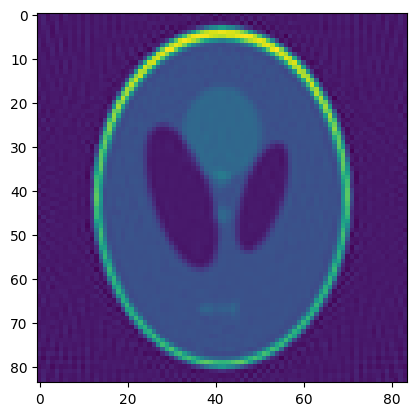

In [21]:
plt.imshow(x_bm3d.reshape(imsize))

# PnP-PGD - TV, DnCNN and DRUNet

In [279]:
iters = 200
x_prox, proxr, proxdiff, proxpairs, proxincr = pnp_pgd(A, gauss_y, x, method = 'proximal', reg_l = 5e-4, iters = iters, sigma = sigma)
x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 5e-4, iters = iters, sigma = sigma)

proximal-PnP PGD iterations: 100%|██████████| 200/200 [00:03<00:00, 50.29it/s]


PnP-proximal Final PSNR: 32.97 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:03<00:00, 53.24it/s]

PnP-tv Final PSNR: 29.71 dB


In [796]:
p = 0
bl = 0
for l in [2900, 3000, ev]:
    x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', iters = 200)
    #x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = 50, L= l)
    if drur[-1] >= p:
        p = drur[-1]
        bl = l 

print("Best PSNR:", p, " with best stepsize:", bl)

tv-PnP PGD iterations: 100%|██████████| 200/200 [00:05<00:00, 35.43it/s]


PnP-tv Final PSNR: 32.72 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:04<00:00, 40.15it/s]


PnP-tv Final PSNR: 32.65 dB


tv-PnP PGD iterations: 100%|██████████| 200/200 [00:05<00:00, 37.33it/s]

PnP-tv Final PSNR: 31.25 dB
Best PSNR: tensor(27.9898)  with best stepsize: 4866.8310546875


In [264]:
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = iters, L = 4000)

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:12<00:00, 15.40it/s]


PnP-DnCNN Final PSNR: 30.99 dB


In [333]:
a, b, c, d, e = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-4, iters = 171, sigma = sigma)
x_dncnn = a

tv-PnP PGD iterations: 100%|██████████| 171/171 [00:03<00:00, 43.52it/s]

PnP-tv Final PSNR: 31.00 dB


In [63]:
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = iters, L = 2900)
x_gs, gsr, gsdiff, gspairs, gsincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = iters, L = 2900)

DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


PnP-DRUNet Final PSNR: 28.01 dB


GS-DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]

PnP-GS-DRUNet Final PSNR: 26.68 dB


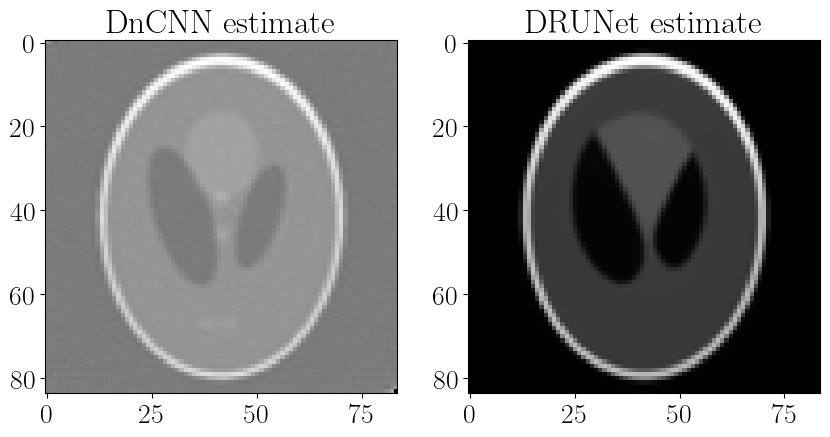

In [276]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('DnCNN estimate')
plt.imshow(x_dncnn.reshape(n,n), cmap = 'gray')

plt.subplot(1, 2, 2)
plt.title('DRUNet estimate')
plt.imshow(x_drunet.reshape(n,n), cmap = 'gray')

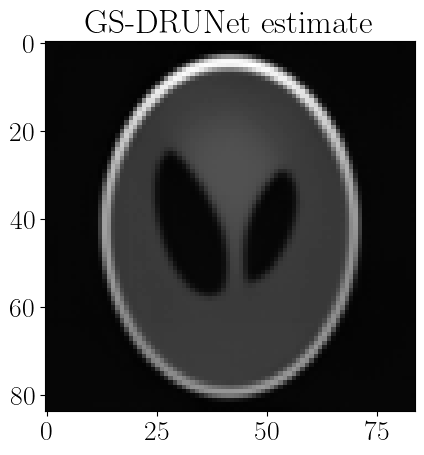

In [275]:
plt.title('GS-DRUNet estimate')
plt.imshow(x_gs.reshape(n,n), cmap = 'gray')

In [198]:
plt.figure(figsize = (10,5.5))
def comparison_plot(norm_res, method, ytitle='PSNR', color='k', title = 'PSNR'):
    K = len(norm_res)

    plt.plot(range(1, len(norm_res) + 1),norm_res, color=color, label=method)
    k = np.arange(K)
    plt.title(title)
    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)


<Figure size 1000x550 with 0 Axes>

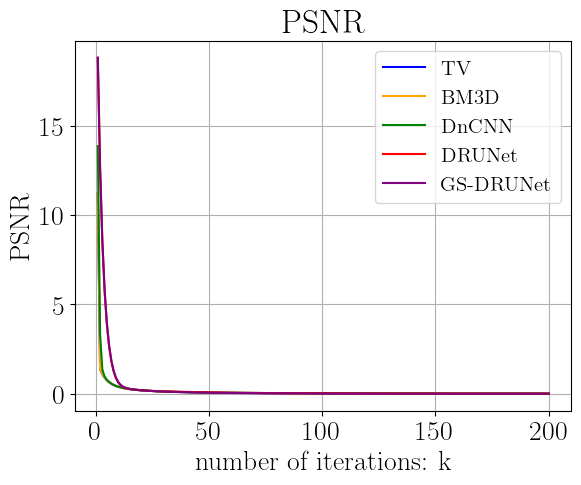

In [274]:
comparison_plot(tvincr,'TV', color='b')
comparison_plot(bm3dincr, 'BM3D', color='orange')
comparison_plot(cnnincr,'DnCNN', color='green')
comparison_plot(druincr,'DRUNet', color='red')
comparison_plot(gsincr,'GS-DRUNet', color='purple')



<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:39: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\2211584302.py:17: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\2211584302.py:39: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\2211584302.py:39: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


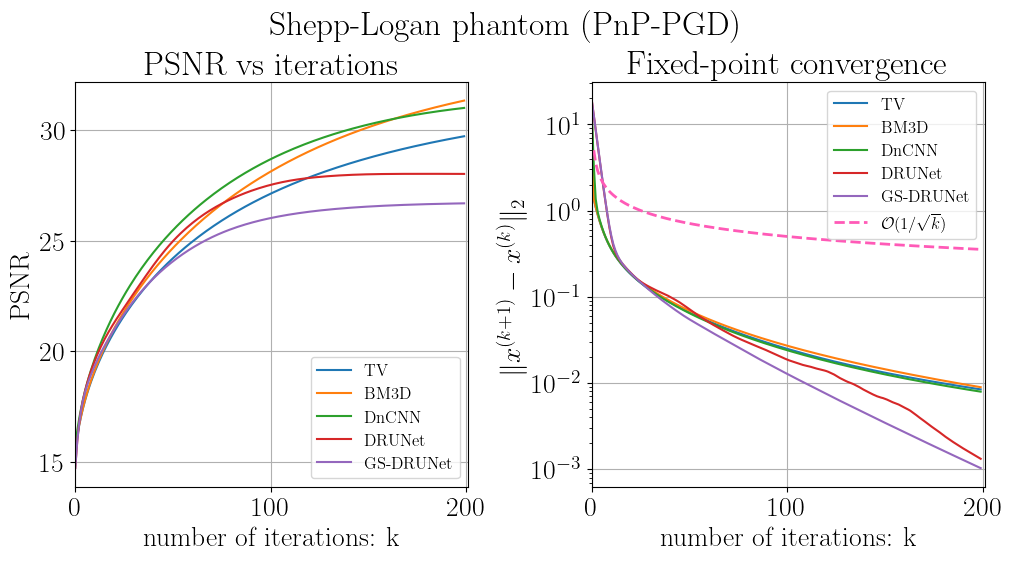

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('Shepp-Logan phantom (PnP-PGD)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, 201])
    ax2.set_xlim([0, 201])
    
    return psnrs[-1]



#proxpsnr = plot_psnrs_differences(aproxpsnr, aproxincr, 'Prox')
tvpsnr = plot_psnrs_differences(tvr, tvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(bm3dr, bm3dincr, 'BM3D')
dncnnpsnr = plot_psnrs_differences(cnnr, cnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(drur, druincr, 'DRUNet')
gsdrunetpsnr = plot_psnrs_differences(gsr, gsincr, 'GS-DRUNet')

psnrs_list = [PSNR(x, gfbp), tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gsdrunetpsnr]

iterations = np.arange(200)

#ax2.semilogy(iterations, 15/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#13A49F', linewidth = 2)
ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)
plt.savefig('plots/PnPPGDPhantomgraphs.png', dpi = 300)

In [ ]:
xf_tv, ftvr, ftvdiff, ftvpairs, ftvincr = pnp_fista(A, gauss_y, x, method = 'tv', reg_l = 1e-5, iters = iters)

In [ ]:
iters = 200
xf_dncnn, fcnnr, fcnndiff, fcnnpairs, fcnnincr = pnp_fista(A, gauss_y, x, method = 'DnCNN', iters = iters)
xf_drunet, fdrur, fdrudiff, fdrupairs, fdruincr = pnp_fista(A, gauss_y, x, method = 'DRUNet', sigma = lamb, iters = iters)
x_gsf, gsf, gsdifff, gspairsf, gsrelf = pnp_fista(A, gauss_y, x, method = 'GS-DRUNet', reg_l = lamb, iters = iters)

In [137]:
imsize = (n, n)

In [169]:
psnrs_list = [PSNR(x, gfbp), tvr[-1], bm3dr[-1], cnnr[-1], drur[-1], gsr[-1]]

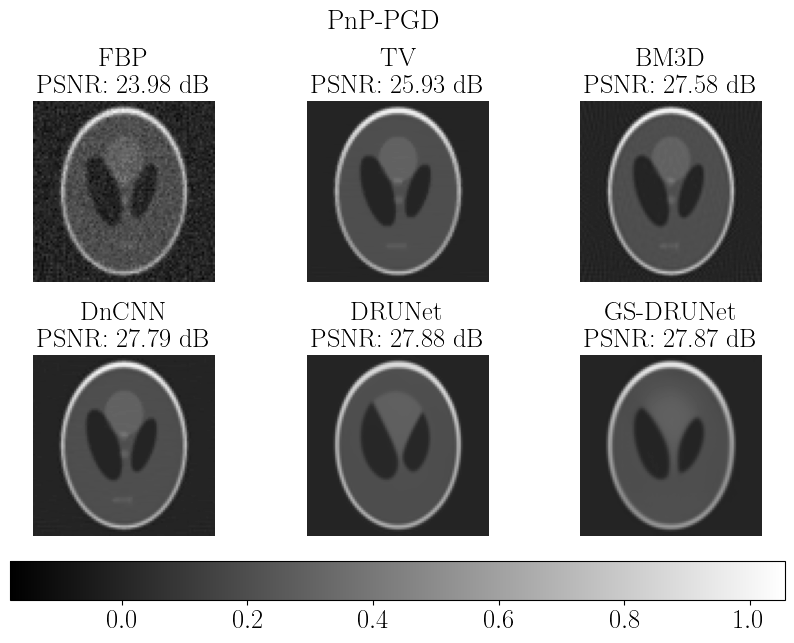

In [334]:
#plotting_estimates1(gfbp.reshape(imsize), xf_tv.reshape(imsize), xf_bm3d.reshape(imsize), xf_dncnn.reshape(imsize), xf_drunet.reshape(imsize), 1, psnrs_list, title='PnP-FISTA')
plotting_estimates1(gfbp.reshape(imsize), x_tv.reshape(imsize), x_bm3d.reshape(imsize), x_dncnn.reshape(imsize), x_drunet.reshape(imsize), x_gs.reshape(imsize), psnrs_list, title='PnP-PGD')
#plt.tight_layout()

In [135]:
comparison_plot(ftvr,'TV-FISTA', color='orange')
comparison_plot(fcnnr,'DnCNN-FISTA', color='green')
comparison_plot(fdrur,'DRUNet-FISTA', color='red')
#comparison_plot(gsdrurf,'GS-DRUNet-FISTA', color='blue')


NameError: name 'comparison_plot' is not defined

# Noise distribution between iterates for the denoisers $(D(x^{(k)}) - x^{(k)})$

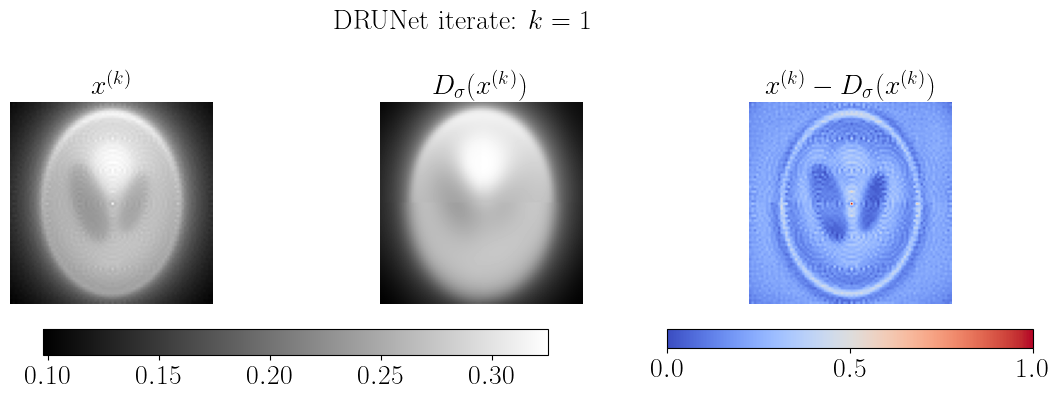

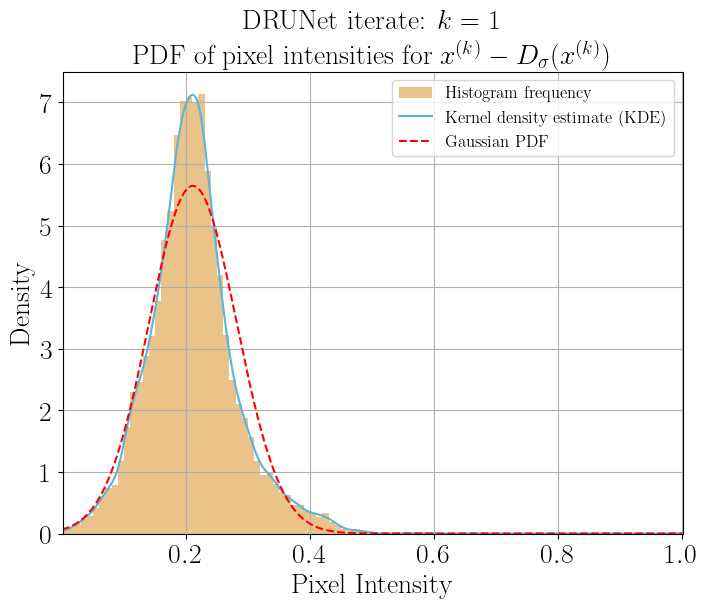

mu=0.21, std=0.07
KS Test: D-statistic=0.0609, p-value=0.0000
Anderson-Darling Test Statistic: 39.64539422955568
Critical value=0.7870
Cramér-von Mises Test Statistic: 6.7814361003528365, p-value: 1.0408685024998476e-10


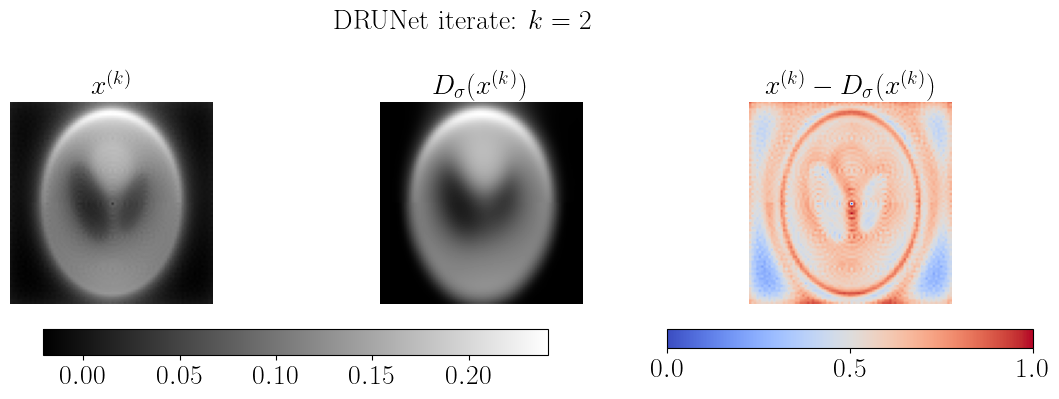

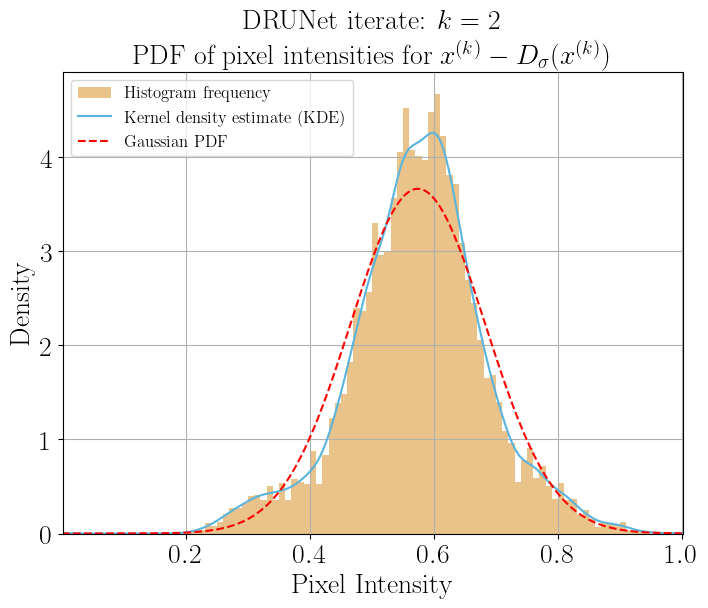

mu=0.57, std=0.11
KS Test: D-statistic=0.0369, p-value=0.0000
Anderson-Darling Test Statistic: 22.907856850436474
Critical value=0.7870
Cramér-von Mises Test Statistic: 3.567181815936871, p-value: 4.229335770489229e-09


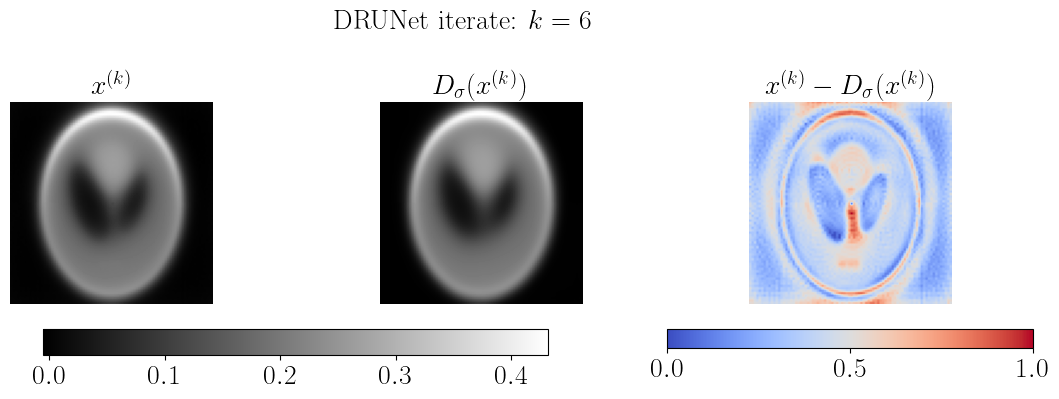

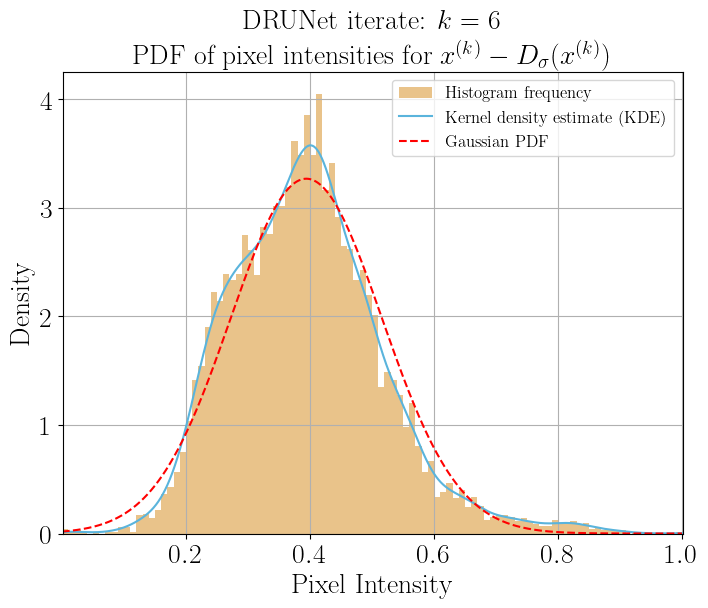

mu=0.39, std=0.12
KS Test: D-statistic=0.0357, p-value=0.0000
Anderson-Darling Test Statistic: 22.20772293578557
Critical value=0.7870
Cramér-von Mises Test Statistic: 2.6810577536376754, p-value: 3.840284108491687e-07


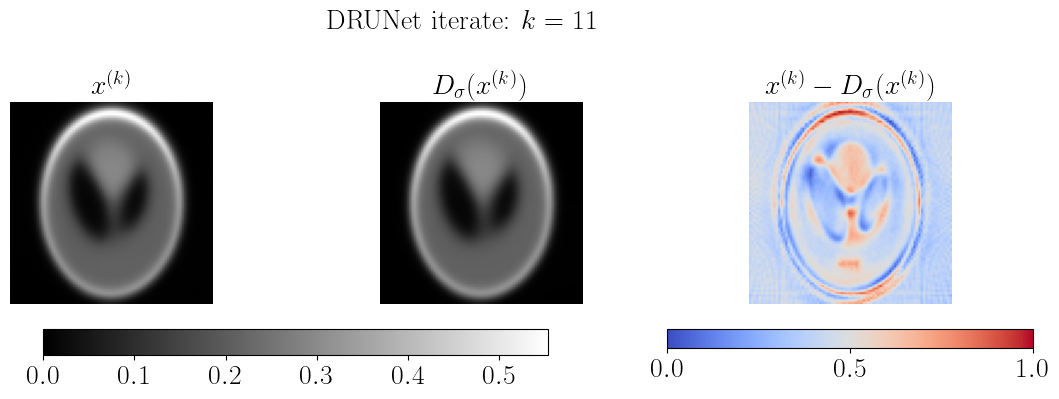

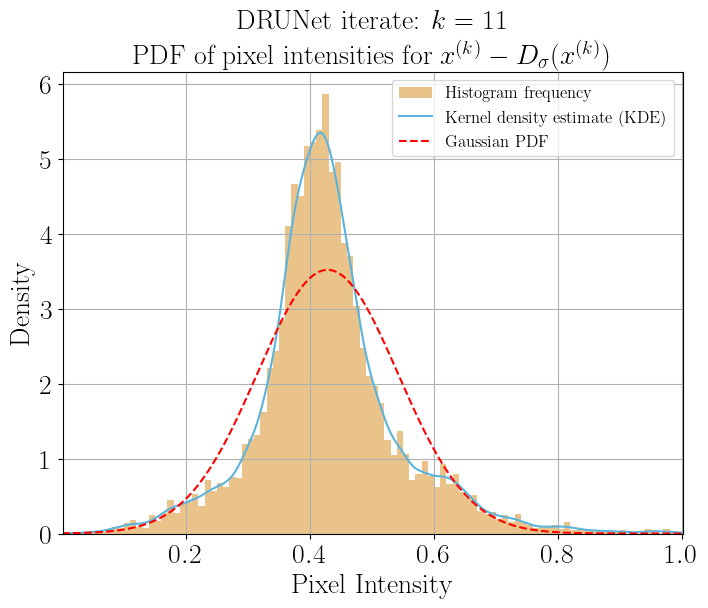

mu=0.43, std=0.11
KS Test: D-statistic=0.0891, p-value=0.0000
Anderson-Darling Test Statistic: 97.46165252477658
Critical value=0.7870
Cramér-von Mises Test Statistic: 18.22717388815643, p-value: 2.7190574236612974e-09


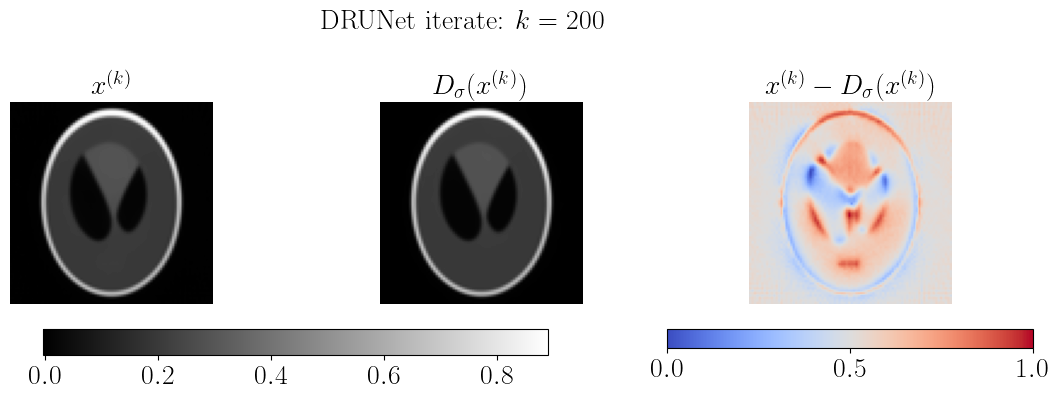

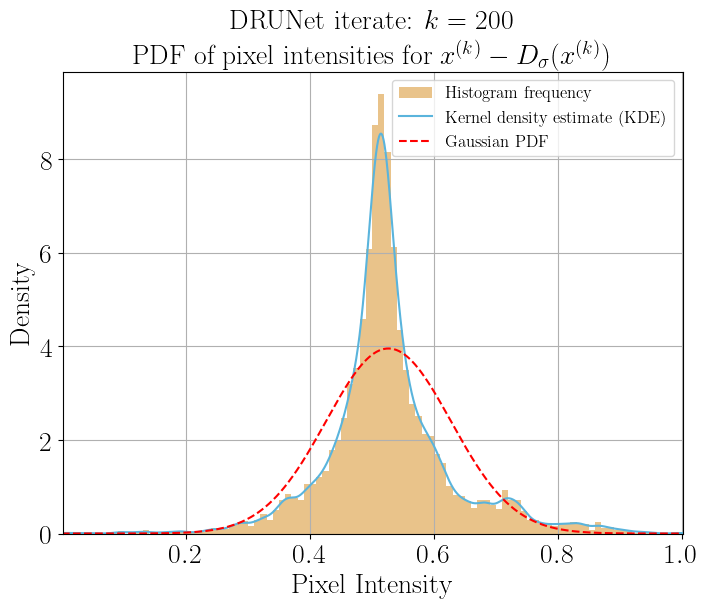

mu=0.53, std=0.10
KS Test: D-statistic=0.1222, p-value=0.0000
Anderson-Darling Test Statistic: 184.38461269824802
Critical value=0.7870
Cramér-von Mises Test Statistic: 35.77204401322687, p-value: 1.2366637047733775e-08


In [325]:
import seaborn as sns
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, cramervonmises, anderson, norm, ecdf
def pdf_plot(noise_diff, iterates_pairs, iteration, title):
    """
    Plotting the differences between inverted and denoised iterates of x^(k)
    """
    fontsize = 20
    fig1, axs = plt.subplots(1, 3, figsize=(12, 4))
    noised_x = iterates_pairs[iteration][0].reshape(imsize)
    denoised_x = iterates_pairs[iteration][1].reshape(imsize)
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    #normalise 2nd colorbar
    #dmin = noise_diff.min()
    #dmax = noise_diff.max()

    fig1.suptitle(title + str(iteration + 1), fontsize = fontsize)
    im1 = axs[0].imshow(noised_x, cmap = 'gray')
    im2 = axs[1].imshow(denoised_x, cmap = 'gray')
    im3 = axs[2].imshow(noise_diff.reshape(imsize), cmap = 'coolwarm')

    axs[0].set_title('$x^{(k)}$', fontsize = fontsize)
    axs[1].set_title('$D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    axs[2].set_title('$x^{(k)} - D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    plt.tight_layout()

    for i in range(3):
        axs[i].axis('off')

 
    #cbar_ax1 = fig1.add_axes([0.1, -0.05, 0.4, 0.02])  # Colorbar for the first two plots
    #cbar_ax2 = fig1.add_axes([0.55, -0.05, 0.4, 0.02])  # Colorbar for the third plot
    
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    cbar1 = fig1.colorbar(im1, ax=axs[:2], orientation='horizontal', fraction=0.1, pad=0.1)
    #cbar1.set_ticks([0.0, 0.25, 0.50, 0.75, 1.0]) 
    
    cbar2 = fig1.colorbar(im3, ax=axs[2], orientation='horizontal', fraction=0.1, pad=0.1)
    cbar2.set_ticks([0, 0.5, 1])  
    
    
    
    plt.show()

    #Normalising the pixel values
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    #noise_diff = (noise_diff - torch.mean(noise_diff))/(torch.std(noise_diff))
    noise_diff_np = noise_diff.numpy().flatten()
    iterate = title + str(iteration+1)

    #Reference gaussian pdf with same mean and standard deviation
    xrange = np.linspace(0, 1, 1000)
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    gaussian_pdf = norm.pdf(xrange, loc=mu, scale=std)
    

    #Compute kernel density estimate (kde for pdf of noise distribution)
    fig2 = plt.figure(figsize=(8,6))
    kde = sm.nonparametric.KDEUnivariate(noise_diff) 
    kde.fit(bw = 'scott')

    peak_index = np.argmax(kde.density)
    peak_value = kde.support[peak_index]
    
    plt.hist(noise_diff, density = True, bins = 100, alpha = 0.5, color="#D58817", label = 'Histogram frequency', weights=np.ones_like(noise_diff) / len(noise_diff))
    plt.plot(kde.support, kde.density, color="#5AB4DC", label = 'Kernel density estimate (KDE)')
    plt.plot(xrange, gaussian_pdf, label='Gaussian PDF', color='red', linestyle='--')
    #sns.kdeplot(noise_diff.numpy(), fill = True, color='g')

    plt.xlim([0.001, 1.001])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title(iterate + " \n PDF of pixel intensities for $x^{(k)} - D_{\\sigma}(x^{(k)})$", fontsize = fontsize)
    plt.grid(True)
    plt.legend(fontsize = 12)
    
    plt.show()
    
    
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    print(f'mu={mu:.2f}, std={std:.2f}')
    print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
    

    result = anderson(noise_diff_np, dist='norm')

    # Get the critical value for the 5% significance level
    critical = result.critical_values[2] 
    print(f'Anderson-Darling Test Statistic: {result.statistic}')
    print(f'Critical value={critical:.4f}')

    result = cramervonmises(noise_diff_np, cdf='norm', args=(mu, std))
    print(f'Cramér-von Mises Test Statistic: {result.statistic}, p-value: {result.pvalue}')
    
    

    
    
shift = 0
iterates = [0, 1, 5 ,10,  199] 
for i in iterates:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate: $k=$ ")
    #pdf_plot(tvdiff[i+shift], tvpairs, iteration = i+shift, title = "TV iterate: $k=$ ")
    #pdf_plot(bm3diff[i+shift], bm3dpairs, iteration = i+shift, title = "BM3D iterate: $k=$ ")
    #pdf_plot(cnndiff[i+shift], cnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$ ")
    pdf_plot(drudiff[i+shift], drupairs, iteration = i+shift, title = "DRUNet iterate: $k=$ ")
    #pdf_plot(gsdiff[i+shift], gspairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$ ")
    

In [246]:
tvpairs[1]

(tensor([0.0521, 0.0528, 0.0527,  ..., 0.0482, 0.0498, 0.0500]),
 tensor([0.0525, 0.0528, 0.0529,  ..., 0.0491, 0.0496, 0.0497]))

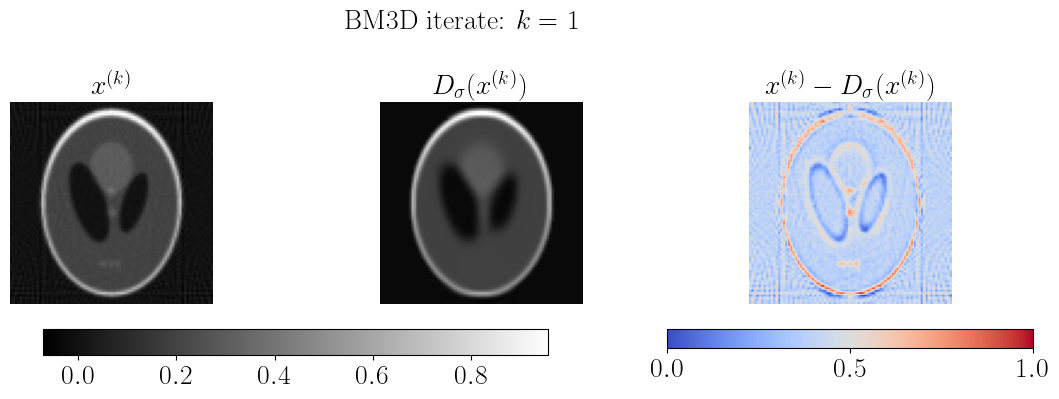

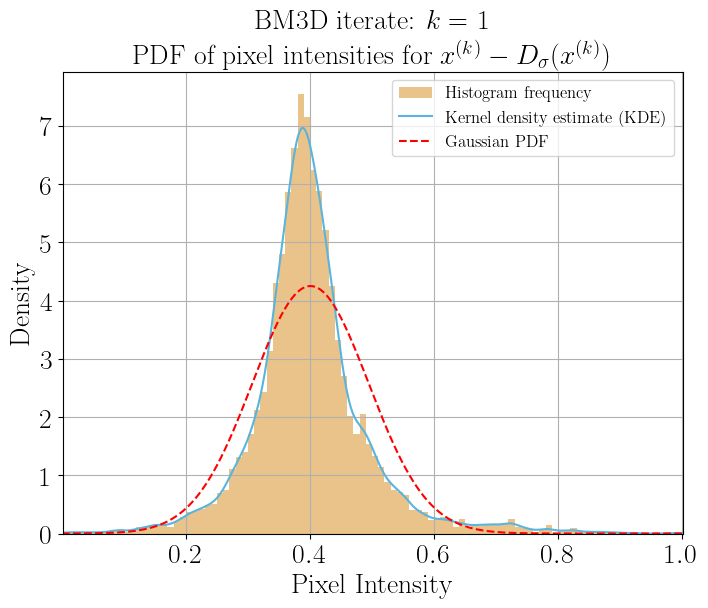

mu=0.40, std=0.09
KS Test: D-statistic=0.1041, p-value=0.0000
Anderson-Darling Test Statistic: 142.35388926877567
Critical value=0.7870
Cramér-von Mises Test Statistic: 25.37926093198655, p-value: 3.855447405776147e-09


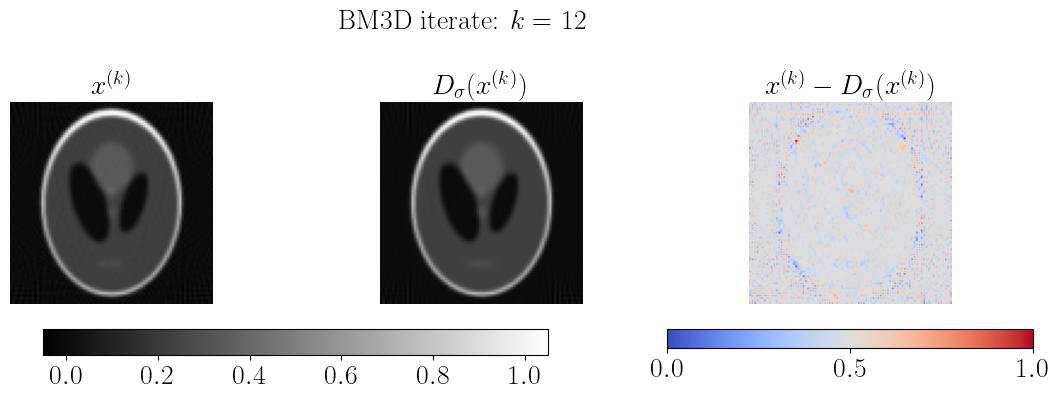

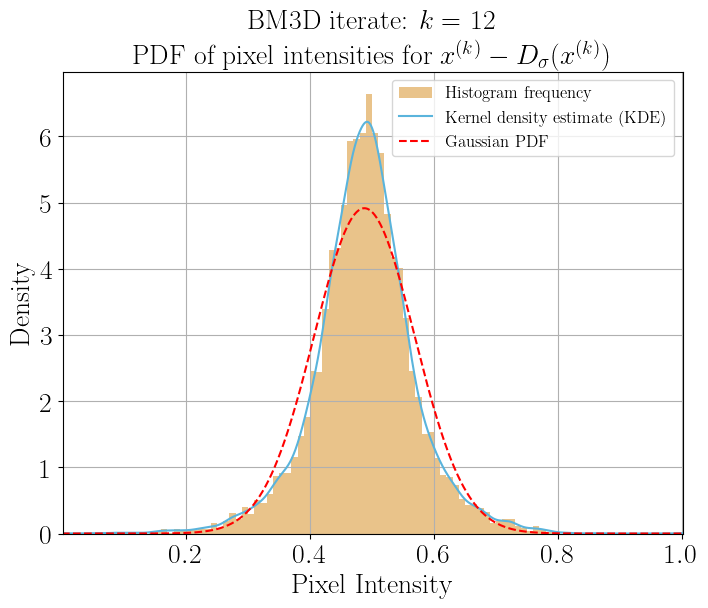

mu=0.49, std=0.08
KS Test: D-statistic=0.0472, p-value=0.0000
Anderson-Darling Test Statistic: 39.63718266274191
Critical value=0.7870
Cramér-von Mises Test Statistic: 6.601910421727864, p-value: 6.027744969827609e-11


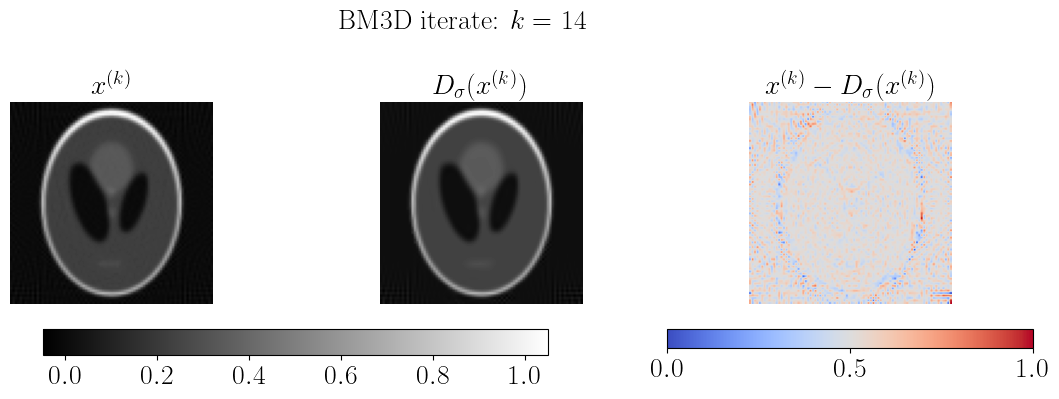

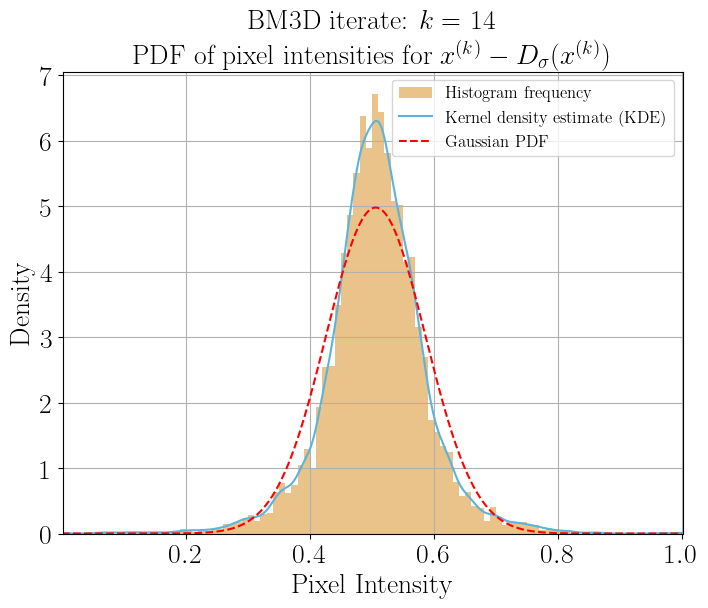

mu=0.51, std=0.08
KS Test: D-statistic=0.0557, p-value=0.0000
Anderson-Darling Test Statistic: 48.08439568518406
Critical value=0.7870
Cramér-von Mises Test Statistic: 7.7357502646720375, p-value: 1.2428333917569034e-09


In [311]:
shift = 0
iterates = [0, 1,  199]
for i in [0, 11, 13]:
    #pdf_plot(aproxdiff[i+shift], aproxpairs, iteration = i+shift, title = "Prox iterate: $k=$ ")
    #pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate: $k=$ ")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$ ")
    #pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate: $k=$ ")
    pdf_plot(abm3diff[i+shift], abm3dpairs, iteration = i, title = "BM3D iterate: $k=$ ")

In [140]:
#PnP-ADMM (torch version)
def pnp_admm(A, b, x_ground_truth, denoiser, niter = 50, beta = 1e+1, lamb = 1, sigma = sigma, tol = 1e-6):
    n = int(torch.sqrt(torch.tensor(A.shape[1])))
    
    # Define the 3 variables for use
    x = torch.zeros_like(x_ground_truth)
    u = torch.zeros_like(x_ground_truth)
    v = torch.zeros_like(x_ground_truth)
    psnrs = []
    iterates_pairs = []
    diffs = []
    increments =[]
    inv_beta = 1/beta

    # PnP ADMM iteration performed on the 3 variables
    for i in tqdm(range(niter), desc= str(denoiser) + '-PnP ADMM iterations'):
        x_k = x
        #print("b shape:", b.shape)
        #measurement = b.reshape((int(torch.ceil(n * torch.sqrt(torch.tensor(2)))), n))
        correction = (A @ (inv_beta * (u - v)))
        #print("correction shape:", correction.shape)
        #print("b shape:", b.shape)
        sinogram = b + correction.reshape(119, 60)
        #print("b shape:", b.shape)
        x = fbp(sinogram, n_angles).flatten().float()
        #print("x fbp shape:", x.shape)

        
        u = apply_denoiser(x + v, lamb, method = denoiser, sigma = sigma).float()
        #print("u shape:", u.shape)
    

        v = (v + x - u).float()

        # Flattening u and v for the next iteration (2D to 1D)
        #u = u.flatten()
        #v = v.flatten()


        increment = torch.norm(x - x_k)
        diff = x - u

        #inverted and denoised iterates stored
        iterates_pairs.append((x, u))
        
        #print("MSE for new iterate:", torch.norm(x_truth - denoised_x)**2)
        
        increments.append(increment)
        #difference between "noisy and denoised iterates"
        diffs.append(diff)

        current_psnr = PSNR(x_ground_truth, x).detach()
        psnrs.append(current_psnr)
        if increment <= tol:
            print('Iteration {}: error between sucessive iterates {:.4e} is less than tolerance {}\n'.format(i, increment, tol))
            break

    print(f"Final PSNR: {current_psnr:.2f} dB")

    return x, psnrs, diffs, iterates_pairs, increments
    



In [214]:
i = 20
#admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = i, beta = 10, lamb = 1)
admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs, abm3dincr = pnp_admm(A, gauss_y, x, 'bm3d', niter = iters)


bm3d-PnP ADMM iterations:  12%|█▏        | 6/50 [00:05<00:38,  1.15it/s]


KeyboardInterrupt: 

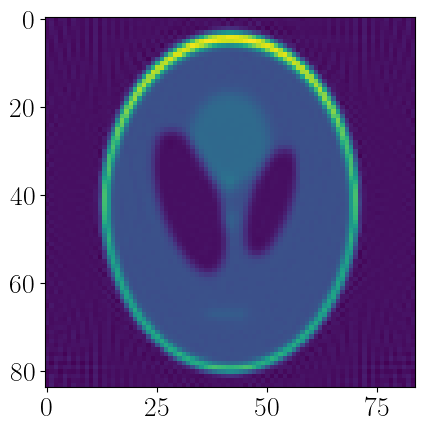

In [142]:
plt.imshow(admm_bm3d.reshape(n,n))

In [211]:
admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = 50, lamb= 1e-1, beta = 6)

tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 30.48it/s]

Final PSNR: 25.93 dB


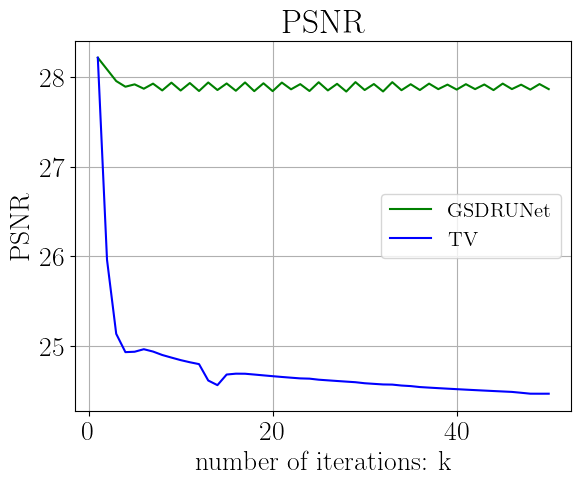

In [209]:
comparison_plot(agsdrunetpsnr, 'GSDRUNet', color= 'green')
comparison_plot(atvpsnr, 'TV', color= 'blue')

In [145]:
iters = 50
#admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = iters, beta = 10, lamb = 1)

admm_dncnn, adncnnpsnr, acnndiff, adncnnpairs, adncnnincr  = pnp_admm(A, gauss_y, x, 'DnCNN', niter = iters)
admm_dru, adrunetpsnr, adrudiff, adrupairs, adruincr = pnp_admm(A, gauss_y, x, 'DRUNet', niter = iters, sigma= sigma)





DnCNN-PnP ADMM iterations: 100%|██████████| 50/50 [00:05<00:00,  9.83it/s]


Final PSNR: 27.79 dB


DRUNet-PnP ADMM iterations: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]

Final PSNR: 27.88 dB


In [146]:
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = iters, sigma = sigma)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it]

Final PSNR: 27.87 dB


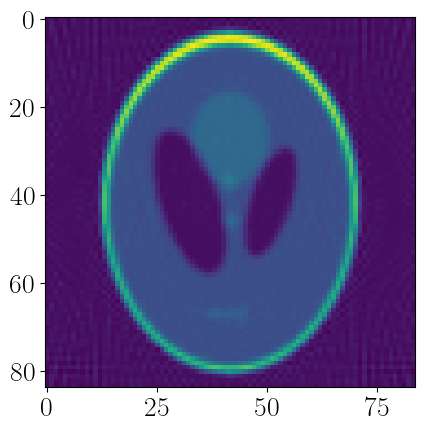

In [918]:
#plt.imshow(admm_dncnn.reshape(n,n))
plt.imshow(admm_dru.reshape(n,n))

In [480]:
best = 0
for b in [1e+3, 1e+2, 1e+1, 1]:
        aa, bb, cc, dd, ee = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 5, beta = b)
        if bb[-1] > best:
            best = bb[-1]
            b_beta = b

print("Best beta:", b_beta, "\n Best PSNR:", best)
#admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 5)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Final PSNR: 25.08 dB


GS-DRUNet-PnP ADMM iterations: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Final PSNR: 25.17 dB


GS-DRUNet-PnP ADMM iterations: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Final PSNR: 25.28 dB


GS-DRUNet-PnP ADMM iterations: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

Final PSNR: 5.15 dB
Best beta: 10.0 
 Best PSNR: tensor(25.2838)


In [199]:
sigma

0.05

In [877]:
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 35)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it]

Final PSNR: 27.70 dB


In [ ]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
betas = [1e+2, 1e+1]
best = 0
b_lamb, b_beta = 0, 0
for lamb in lambdas:
    for beta in betas:
        tv, tvp, tvd, tvpairs = pnp_admm(A, gauss_y, x, 'tv', niter = iters, beta = beta, lamb= lamb)
        if tvp[-1] > best:
            best = tvp[-1]
            b_lamb, b_beta = lamb, beta

print("Best beta:", b_beta, "\n Best lambda:", b_lamb)
beta = 1e+1
lamb = 1


<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:37: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\1911584412.py:18: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\1911584412.py:37: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 14/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_28328\1911584412.py:37: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 14/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


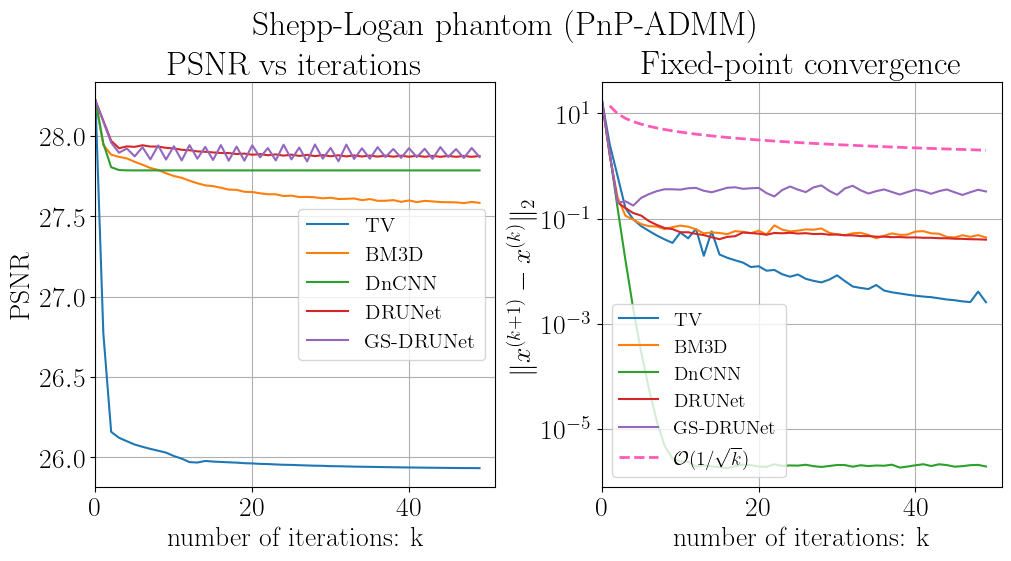

In [189]:
#Main plotting and reconstruction functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('Shepp-Logan phantom (PnP-ADMM)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, 51])
    ax2.set_xlim([0, 51])
    
    return psnrs[-1]



#proxpsnr = plot_psnrs_differences(aproxpsnr, aproxincr, 'Prox')
tvpsnr = plot_psnrs_differences(atvpsnr, atvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(abm3dpsnr, abm3dincr, 'BM3D')
dncnnpsnr = plot_psnrs_differences(adncnnpsnr, adncnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(adrunetpsnr, adruincr, 'DRUNet')
gsdrunetpsnr = plot_psnrs_differences(agsdrunetpsnr, agsdruincr, 'GS-DRUNet')
iterations = np.arange(50)

#ax2.semilogy(iterations, 80/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '', linewidth = 2)
ax2.semilogy(iterations, 14/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

psnrs_list = [PSNR(x, gfbp), tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gsdrunetpsnr]

ax1.legend()
ax2.legend(fontsize = 14, loc = 'best')
plt.savefig('plots/PnPADMMPhantomGraphs.png', dpi = 300)

In [443]:
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          "font.size": 20,
          "text.usetex": True,
          "font.family": "Computer Modern Roman",
          #"label.fontsize": 18
          }
plot.rcParams.update(params)

In [162]:
def plotting_estimates1(fbp, x1, x2, x3, x4, x5, psnrs_list, title):
    size = 19
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(title, size = 20, y = 1.02)

    vmin = min(fbp.min(), x1.min(), x2.min(), x3.min(), x4.min(), x5.min())
    vmax = max(fbp.max(), x1.max(), x2.max(), x3.max(), x4.max(), x5.max())

    # Plotting the images
    im0 = axs[0, 0].imshow(fbp, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 0].set_title(f"FBP \n PSNR: {psnrs_list[0]:.2f} dB", fontsize=size)
    axs[0, 1].imshow(x1, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 1].set_title(f'TV \n PSNR: {psnrs_list[1]:.2f} dB', fontsize=size)
    axs[0, 2].imshow(x2, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 2].set_title(f'BM3D \n PSNR: {psnrs_list[2]:.2f} dB', fontsize=size)
    axs[1, 0].imshow(x3, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 0].set_title(f'DnCNN \n PSNR: {psnrs_list[3]:.2f} dB', fontsize=size)
    axs[1, 1].imshow(x4, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 1].set_title(f'DRUNet \n PSNR: {psnrs_list[4]:.2f} dB', fontsize=size)
    axs[1, 2].imshow(x5, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 2].set_title(f'GS-DRUNet \n PSNR: {psnrs_list[5]:.2f} dB', fontsize=size)

    # Adding a color bar for the whole figure
    cbar = fig.colorbar(im0, ax=axs, orientation='horizontal', fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=size)

    """
    #axs[0, 0].set_title("Ground Truth", fontsize = size)
    #axs[0, 0].imshow(gt, cmap='gray')
    axs[0, 0].set_title(f"FBP \n PSNR: {psnrs_list[0]:.2f} dB", fontsize = size)
    axs[0, 0].imshow(fbp, cmap='gray')
    axs[0, 1].set_title(f'TV \n PSNR: {psnrs_list[1]:.2f} dB', fontsize = size)
    axs[0, 1].imshow(x1, cmap='gray')
    axs[0, 2].set_title(f'BM3D \n PSNR: {psnrs_list[2]:.2f} dB', fontsize = size)
    axs[0, 2].imshow(x2, cmap='gray')
    axs[1, 0].set_title(f'DnCNN \n PSNR: {psnrs_list[3]:.2f} dB', fontsize = size)
    axs[1, 0].imshow(x3, cmap='gray')
    axs[1, 1].set_title(f'DRUNet \n PSNR: {psnrs_list[4]:.2f} dB', fontsize = size)
    axs[1, 1].imshow(x4, cmap='gray')
    axs[1, 2].set_title(f'GS-DRUNet \n PSNR: {psnrs_list[5]:.2f} dB', fontsize = size)
    axs[1, 2].imshow(x5, cmap='gray')
    """

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')

imsize = (n, n)

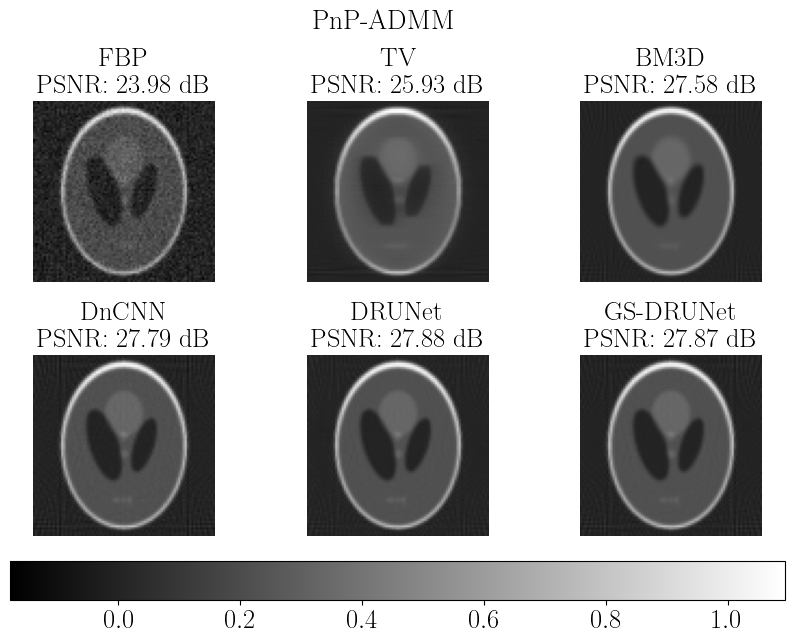

In [208]:
plotting_estimates1(gfbp.reshape(imsize), admm_tv.reshape(imsize), admm_bm3d.reshape(imsize), admm_dncnn.reshape(imsize), admm_dru.reshape(imsize), admm_gsdru.reshape(imsize), psnrs_list, title='PnP-ADMM')

# Residual noise distribution
## Figures
- Before - $x^{(k)}$ image
- After - $D(x^{(k)})$ image
- $D(x) - x$ image
- Histogram (pdf) of the individual pixels of $(D(x^{(k)}_i) - x^{(k)}_i)$ (784 samples per iterate MNIST, 7056 samples per iterate Phantom)



In [304]:
def ks_test(residual_noise, method):
    """
    Performs Kolmogorov-Smirnov (KS) hypothesis test to 5% significance level (whether the residual noise distribution for the denoiser is the shape of a Gaussian)
    """
    total = 0
    length = len(residual_noise)
    for i in range(length):
        w = residual_noise[i]
        noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w)) #normalise
        noise_diff_np = noise_diff.numpy().flatten()
        #ks test
        mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
        D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std)) #KS test with mu and std from the residual noise
        #print(f'{i:}th iteration, KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
        if p_value >= 0.05:
            print(i)
            total +=1
    
    print("Number of null hypothesis for ", method, " accepted:", total)



def ad_test(residual_noise, method):
    """
    Performs Anderson-Darling hypothesis test to 5% significance level (whether the residual noise distribution for the denoiser is the shape of a Gaussian)
    """
    total = 0
    length = len(residual_noise)
    for i in range(length):
        w = residual_noise[i]
        noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w)) #normalise
        noise_diff_np = noise_diff.numpy().flatten()
        #ks test
        result = anderson(noise_diff_np, dist = 'norm')
        if result.statistic <= result.critical_values[2]:
            print(i)
            total +=1
    
    print("Number of null hypothesis for ", method, " accepted:", total)



def cvm_test(residual_noise, method):
    """
    Performs Cramer Von-Misces hypothesis test to 5% significance level (whether the residual noise distribution for the denoiser is the shape of a Gaussian)
    """
    total = 0
    length = len(residual_noise)
    for i in range(length):
        w = residual_noise[i]
        noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w)) #normalise
        noise_diff_np = noise_diff.numpy().flatten()
        mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
        
        #ks test
        result = cramervonmises(noise_diff_np, cdf='norm', args=(mu, std))
        if result.pvalue >= 0.025:
            print(i)
            total +=1
    
    print("Number of null hypothesis for ", method, " accepted:", total)
    
 

In [240]:
ks_test(tvdiff, "TV")
ks_test(bm3diff, "BM3D")
ks_test(cnndiff, "DnCNN")
ks_test(drudiff, "DRUNet")
ks_test(gsdiff, "GS-DRUNet")


ks_test(atvdiff, "TV")
ks_test(abm3diff, "BM3D")
ks_test(acnndiff, "DnCNN")
ks_test(adrudiff, "DRUNet")
ks_test(agsdrudiff, "GS-DRUNet")


Number of null hypothesis for  TV  accepted: 0
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0
11
13
Number of null hypothesis for  TV  accepted: 2
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0


In [305]:
cvm_test(tvdiff, "TV")
cvm_test(bm3diff, "BM3D")
cvm_test(cnndiff, "DnCNN")
cvm_test(drudiff, "DRUNet")
cvm_test(gsdiff, "GS-DRUNet")


cvm_test(atvdiff, "TV")
cvm_test(abm3diff, "BM3D")
cvm_test(acnndiff, "DnCNN")
cvm_test(adrudiff, "DRUNet")
cvm_test(agsdrudiff, "GS-DRUNet")

Number of null hypothesis for  TV  accepted: 0
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0
11
13
Number of null hypothesis for  TV  accepted: 2
Number of null hypothesis for  BM3D  accepted: 0
Number of null hypothesis for  DnCNN  accepted: 0
Number of null hypothesis for  DRUNet  accepted: 0
Number of null hypothesis for  GS-DRUNet  accepted: 0


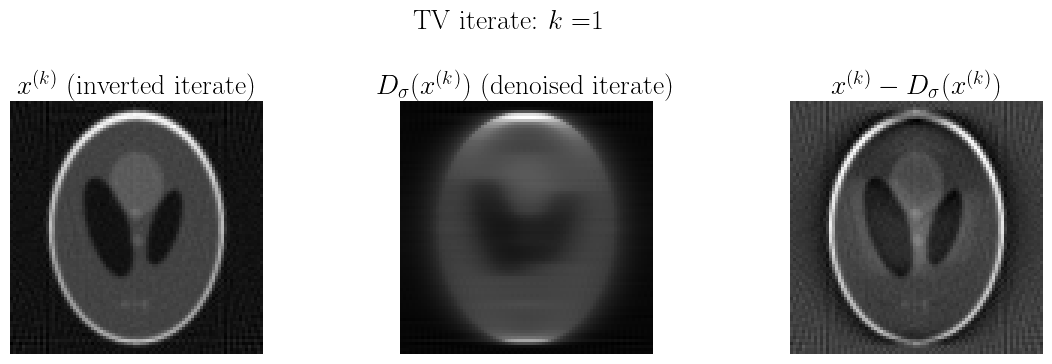

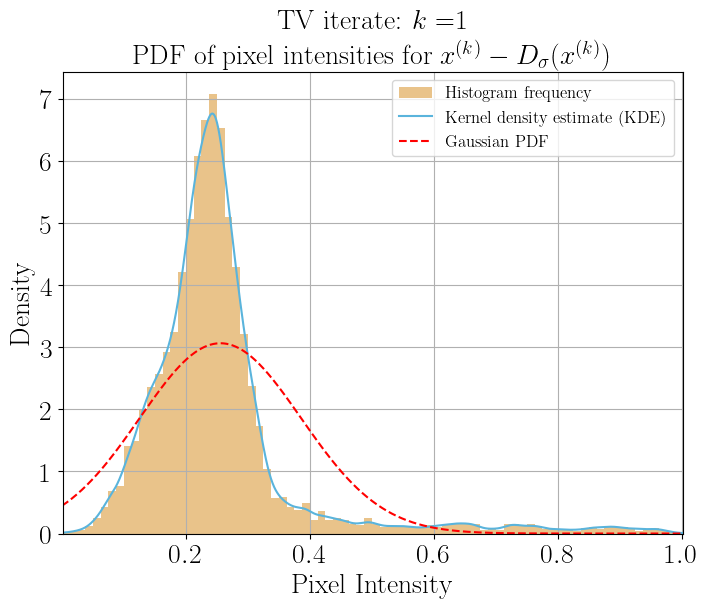

mu=0.26, std=0.13
KS Test: D-statistic=0.2005, p-value=0.0000


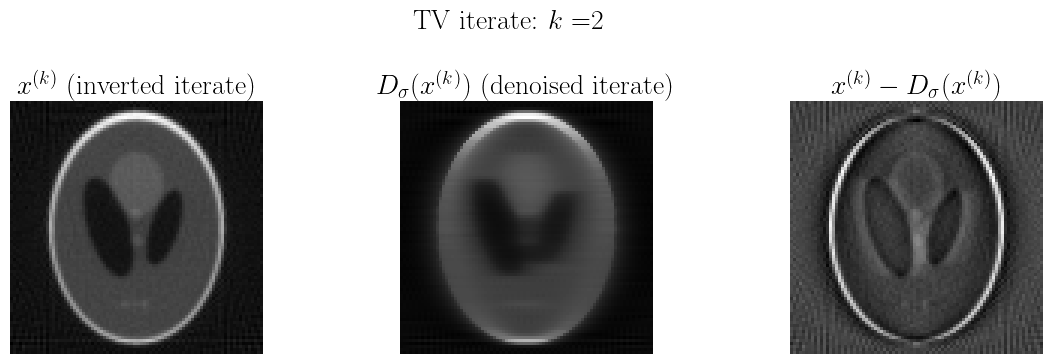

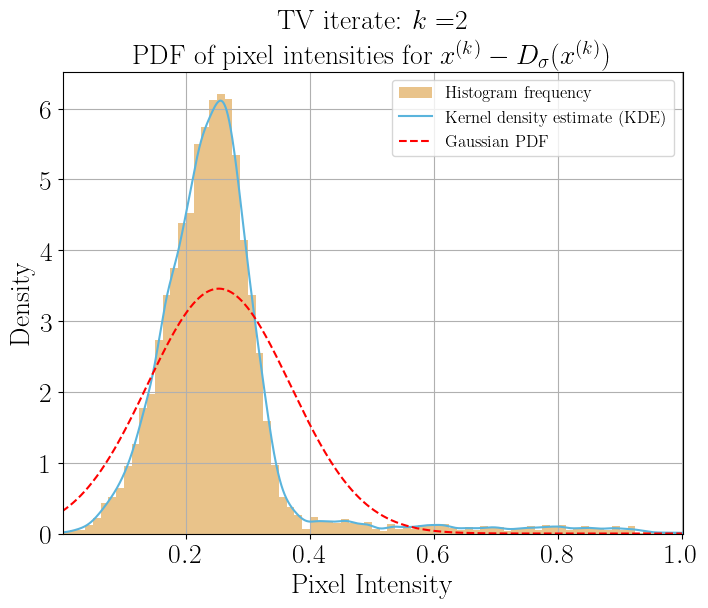

mu=0.25, std=0.12
KS Test: D-statistic=0.1703, p-value=0.0000


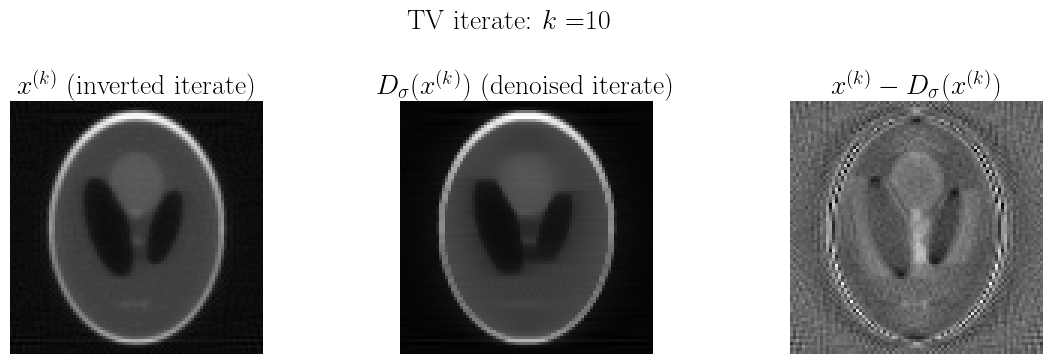

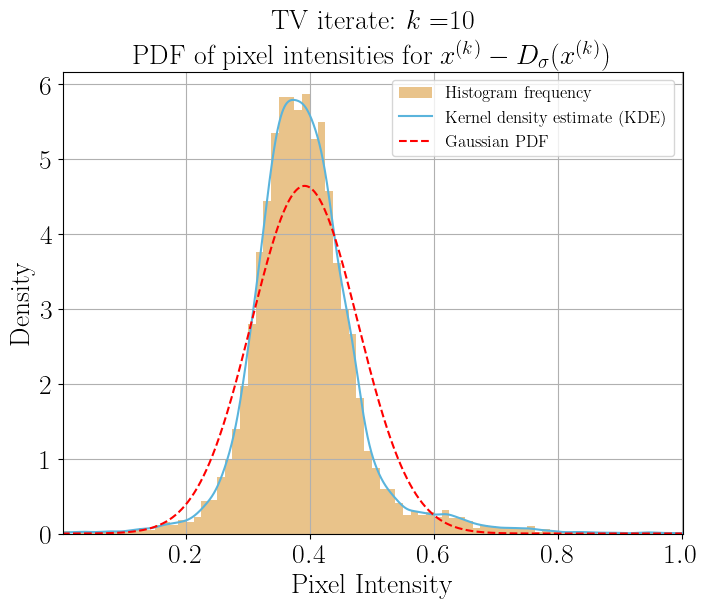

mu=0.39, std=0.09
KS Test: D-statistic=0.0742, p-value=0.0000


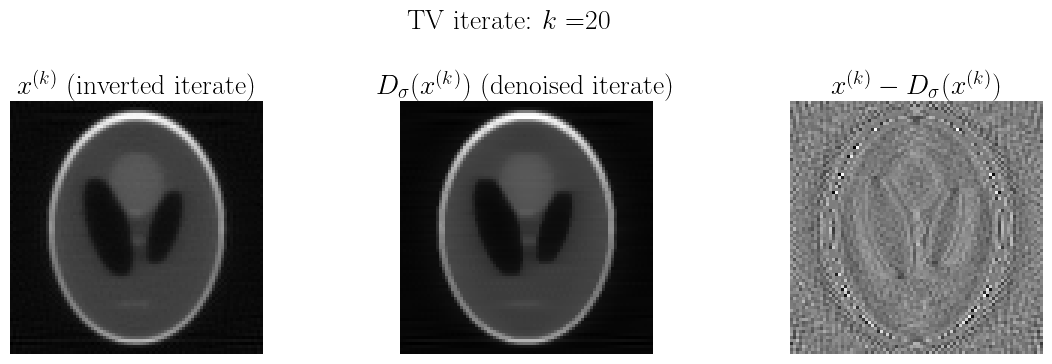

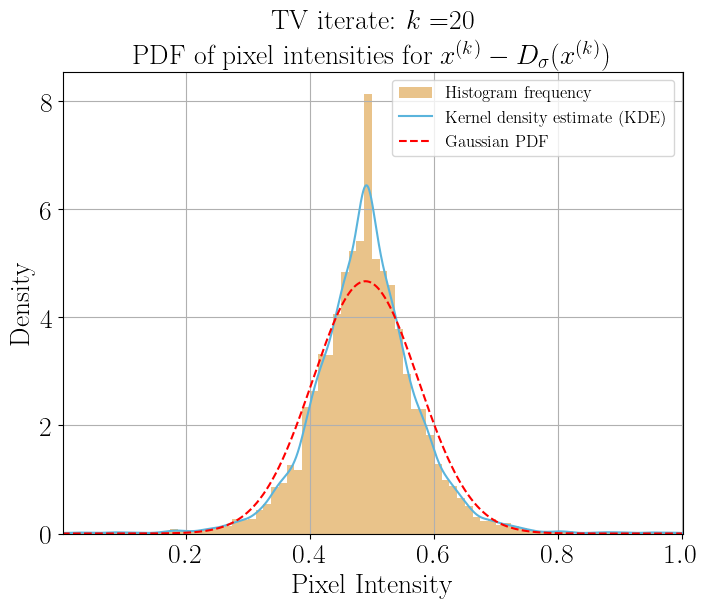

mu=0.49, std=0.09
KS Test: D-statistic=0.0467, p-value=0.0000


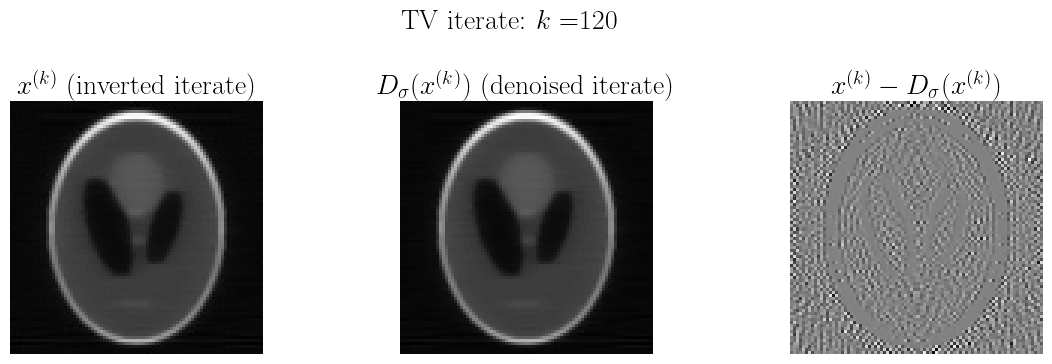

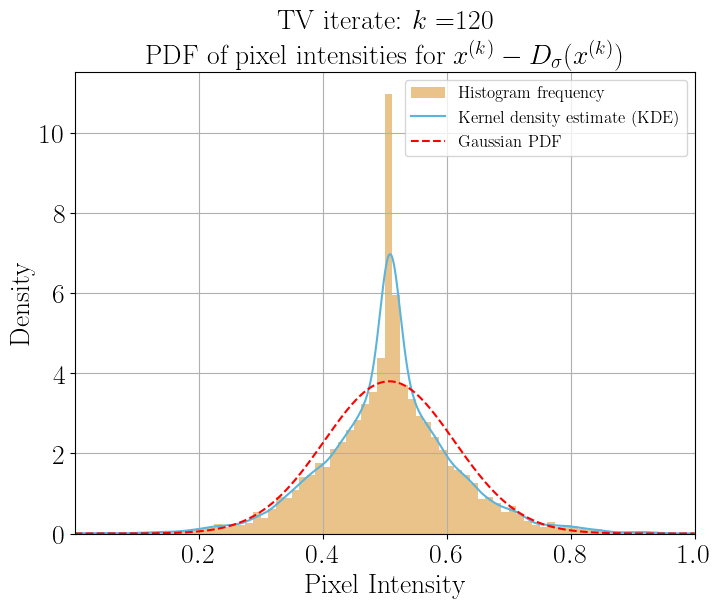

mu=0.51, std=0.11
KS Test: D-statistic=0.0656, p-value=0.0000


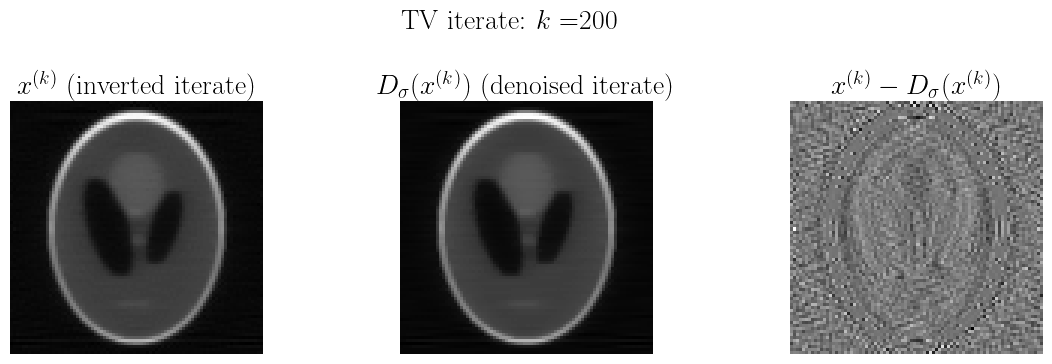

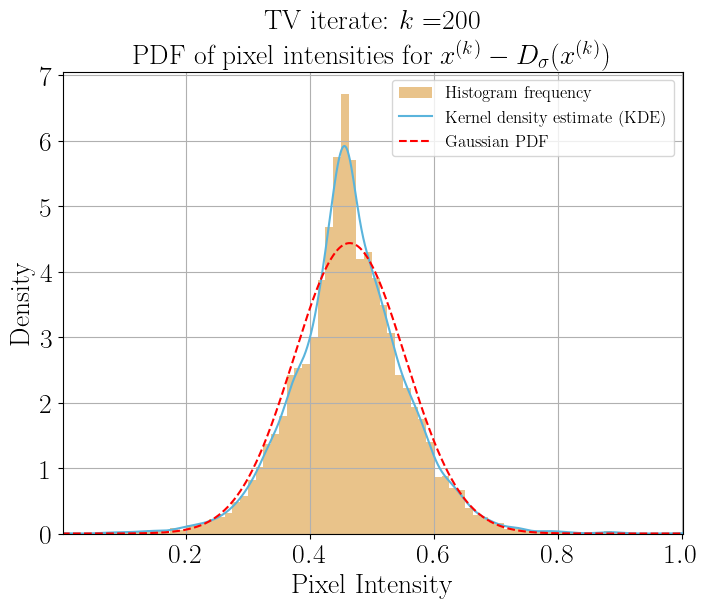

mu=0.46, std=0.09
KS Test: D-statistic=0.0387, p-value=0.0000


In [512]:
shift = 0
iterates = [0, 1, 9, 19, 119,  199]
for i in iterates:
    #pdf_plot(aproxdiff[i+shift], aproxpairs, iteration = i+shift, title = "Prox iterate: $k=$")
    pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate: $k=$")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$")
    #pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate: $k=$")
    #pdf_plot(bm3dd[i+shift-50], bm3dpairs, iteration = i+shift-50, title = "BM3D iterate: $k=$")

In [ ]:
for i in range(1, 200):
    w = adrudiff[i]
    noise_diff = (w - torch.min(w))/(torch.max(w) - torch.min(w))
    noise_diff_np = noise_diff.numpy().flatten()
    normalized_gaussian = norm.cdf(np.linspace(-3, 3, len(noise_diff_np))) 
    #ks test
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    print(f'{i:}th iteration, KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')

In [ ]:
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, cramervonmises, norm
def pdf_plot(noise_diff, iterates_pairs, iteration, title):
    """
    Plotting the differences between inverted and denoised iterates of x^(k)
    """
    fontsize = 20
    fig1, axs = plt.subplots(1, 3, figsize=(12, 4))
    noised_x = iterates_pairs[iteration][0].reshape(imsize)
    denoised_x = iterates_pairs[iteration][1].reshape(imsize)
    fig1.suptitle(title + str(iteration + 1), fontsize = fontsize)
    axs[0].imshow(noised_x, cmap = 'gray')
    axs[1].imshow(denoised_x, cmap = 'gray')
    axs[2].imshow(noise_diff.reshape(imsize), cmap = 'gray')

    axs[0].set_title('Inverted iterate', fontsize = fontsize)
    axs[1].set_title('Denoised iterate', fontsize = fontsize)
    axs[2].set_title('$x^{(k)} - D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    plt.tight_layout()
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    plt.show()

    #Normalising the pixel values
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    noise_diff_np = noise_diff_np = noise_diff.numpy().flatten()
    iterate = title + str(iteration+1)

    #Compute kernel density estimate (kde for pdf of noise distribution)
    fig2 = plt.figure(figsize=(8,6))
    kde = sm.nonparametric.KDEUnivariate(noise_diff) 
    kde.fit()

    peak_index = np.argmax(kde.density)
    peak_value = kde.support[peak_index]
    # Set the range around the peak
    x_range = kde.support[(kde.support >= peak_value - 2) & (kde.support <= peak_value + 2)]
    
    #fig = plt.figure(layout="constrained", figsize=(12, 5))
    plt.hist(noise_diff, density = True, bins = 80, alpha = 0.5, color="#D58817", label = 'Histogram frequency')
    plt.plot(kde.support, kde.density, color="#5AB4DC", label = 'Estimated PDF')
    #sns.kdeplot(noise_diff.numpy(), fill = True, color='g')

    plt.xlim([0.001, peak_value + 0.4])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title(iterate + " \nPDF of pixel intensities for $x^{(k)} - D_{\\sigma}(x^{(k)})$", fontsize = fontsize)
    plt.grid(True)
    plt.legend()
    
    plt.show()
    
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    print(f'mean={mu:.4f}, standard deviation={std:.4f}')
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    cdf = norm.cdf(noise_diff_np, loc=mu, scale=std)
    result = cramervonmises(array[noise_diff_np], cdf=cdf)

    print(f'CvM Test: W-statistic={result.statistic:.4f}, p-value={result.pvalue:.4f}')

    print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
    
    if p_value > 0.05:
        print("The residual noise difference appears to follow a Gaussian distribution (accept H0)")
    else:
        print("The residual noise difference does not appear to follow a Gaussian distribution (reject H0)")
    